## Email Spam Detection

In [1]:
#loading the basic libraries required for the model building, data analysis and wrangling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample

import nltk
from nltk.corpus import stopwords

import re
import string

import warnings
warnings.filterwarnings('ignore')

In [2]:
#loading the dataset
df = pd.read_csv("messages.csv")

In [3]:
#checking the top five data of the dataset
df.head()

subject  \
0            job posting - apple-iss research center   
1                                                NaN   
2  query : letter frequencies for text identifica...   
3                                               risk   
4                           request book information   

                                             message  label  
0  content - length : 3386 apple-iss research cen...      0  
1  lang classification grimes , joseph e . and ba...      0  
2  i am posting this inquiry for sergei atamas ( ...      0  
3  a colleague and i are researching the differin...      0  
4  earlier this morning i was on the phone with a...      0

In [4]:
#dropping the 'subject' column
df.drop(['subject'],axis=1,inplace=True)

In [5]:
#checking the basic information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2893 entries, 0 to 2892
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  2893 non-null   object
 1   label    2893 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 45.3+ KB


In [6]:
#checking the basic information of the dataset after removinf duplicates
df.drop_duplicates(inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2859 entries, 0 to 2892
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  2859 non-null   object
 1   label    2859 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 67.0+ KB
None


In [8]:
#Ratio
print ('spam ratio = ', round(len(df[df['label']==1]) / len(df.label),2)*100,'%')
print ('ham ratio  = ', round(len(df[df['label']==0]) / len(df.label),2)*100,'%')

spam ratio =  16.0 %
ham ratio  =  84.0 %


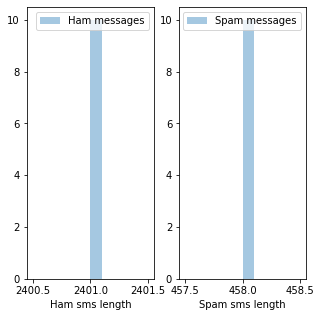

In [20]:
# Message distribution BEFORE cleaning
f,ax = plt.subplots(1,2,figsize = (5,5))

sns.distplot(len(df[df['label']==0]),bins=10,ax=ax[0],label='Ham messages')
ax[0].set_xlabel('Ham sms length')
ax[0].legend()
sns.distplot(len(df[df['label']==1]),bins=10,ax=ax[1],label='Spam messages')
ax[1].set_xlabel('Spam sms length')
ax[1].legend()

plt.show()

In [21]:
# Separate majority and minority classes
df_majority = df[df.label==0] #ham
df_minority = df[df.label==1] #spam
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,       #sample with replacement
                                 n_samples=2401,     #to match majority class
                                 random_state=123)   #reproducible results
 
# Combine majority class with upsampled minority class
spam_df = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
spam_df.label.value_counts()

1    2401
0    2401
Name: label, dtype: int64

In [22]:
# Convert all messages to lower case
spam_df['message'] = spam_df['message'].str.lower()

In [23]:
# Replace whitespace between terms with a single space
spam_df['message'] = spam_df['message'].str.replace('\s+', ' ')

# Remove leading and trailing whitespace
spam_df['message'] = spam_df['message'].str.replace('^\s+|\s+?$', '')

In [24]:
def text(message):
    
    #Check characters to see if they are in punctuation
    no_punc = [char for char in message if char not in string.punctuation]

    #Join the characters again to form the string.
    no_punc = ''.join(no_punc)
    
    #Now just remove any stopwords
    return [word for word in no_punc.split() if word not in stopwords.words('english')]

In [25]:
spam_df['message'].apply(text)

0       [content, length, 3386, appleiss, research, ce...
1       [lang, classification, grimes, joseph, e, barb...
2       [posting, inquiry, sergei, atamas, satamas, um...
3       [colleague, researching, differing, degrees, r...
4       [earlier, morning, phone, friend, mine, living...
                              ...                        
2704    [online, business, got, frustrated, tried, fre...
1496    [nt, want, receive, emails, click, following, ...
158     [remove, instructions, remove, requests, respe...
956     [biggest, boldest, dirtiest, adult, site, net,...
1117    [save, hundreds, dollars, per, month, home, mo...
Name: message, Length: 4802, dtype: object

In [26]:
#Convert text into vectors using CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
x = spam_df['message']
y = spam_df['label']
cv = CountVectorizer()
x= cv.fit_transform(x)

In [27]:
#Split feature and label
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

In [28]:
#Instantiate MultinomialNB classifier
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB().fit(x_train, y_train)

In [29]:
#Train and predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
pred = classifier.predict(x_test)
print(classification_report(y_test, pred))
print()
print('Confusion Matrix:\n',confusion_matrix(y_test, pred))
print()
print('Accuracy : ',accuracy_score(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       471
           1       0.99      1.00      0.99       490

    accuracy                           0.99       961
   macro avg       0.99      0.99      0.99       961
weighted avg       0.99      0.99      0.99       961


Confusion Matrix:
 [[466   5]
 [  2 488]]

Accuracy :  0.9927159209157128


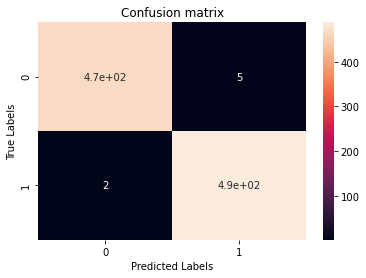

In [30]:
# plot confusion matrix heatmap
conf_mat = confusion_matrix(y_test,pred)
sns.heatmap(conf_mat,annot=True)

ax=plt.subplot()
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion matrix')
plt.show()